In [123]:
%matplotlib notebook
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [124]:
import numpy as np
import pandas as pd

In [125]:
import datetime as dt
from datetime import date, timedelta

# Reflect Tables into SQLAlchemy ORM

In [126]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy import inspect

In [127]:
engine = create_engine('sqlite:///hawaii.sqlite')

In [128]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [129]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [130]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [131]:
inspector = inspect(engine)
print(inspector.get_columns('Measurement'))

[{'name': 'id', 'type': INTEGER(), 'nullable': False, 'default': None, 'autoincrement': 'auto', 'primary_key': 1}, {'name': 'station', 'type': TEXT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}, {'name': 'date', 'type': TEXT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}, {'name': 'prcp', 'type': FLOAT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}, {'name': 'tobs', 'type': FLOAT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}]


In [132]:
inspector = inspect(engine)
print(inspector.get_columns('Station'))

[{'name': 'id', 'type': INTEGER(), 'nullable': False, 'default': None, 'autoincrement': 'auto', 'primary_key': 1}, {'name': 'station', 'type': TEXT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}, {'name': 'name', 'type': TEXT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}, {'name': 'latitude', 'type': FLOAT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}, {'name': 'longitude', 'type': FLOAT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}, {'name': 'elevation', 'type': FLOAT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}]


In [133]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [134]:
# looking for the last entry in the table
last_entry = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(last_entry)

('2017-08-23',)


In [135]:
# to retreive the last 12 months of data
last_year_data = dt.date(2017,8,23) - dt.timedelta(days = 365)
print(last_year_data)

2016-08-23


In [136]:
# let's pull the precipitation data for the last year. The only table showing prec data is MEASUREMENTS
precipitation_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date > last_year_data).\
    order_by(Measurement.date).all()

# make it a dataframe
precipitation_DF = pd.DataFrame(precipitation_data)
#precipitation_DF.head()

precipitation_DF['date_2'] = pd.to_datetime(precipitation_DF['date']).dt.date
precipitation_DF.head()

,date,prcp,date_2
0,2016-08-24,0.08,2016-08-24
1,2016-08-24,2.15,2016-08-24
2,2016-08-24,2.28,2016-08-24
3,2016-08-24,NaN,2016-08-24
4,2016-08-24,1.22,2016-08-24


In [137]:
precipitation_DF = precipitation_DF[['date_2', 'prcp', 'date']]
precipitation_DF.set_index("date_2", drop=True)
del precipitation_DF['date']
precipitation_DF.head()

,date_2,prcp
0,2016-08-24,0.08
1,2016-08-24,2.15
2,2016-08-24,2.28
3,2016-08-24,NaN
4,2016-08-24,1.22


In [138]:
precipitation_DF.set_index("date_2", inplace=True)
precipitation_DF.head()

,prcp
date_2,
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,NaN
2016-08-24,1.22


<IPython.core.display.Javascript object>


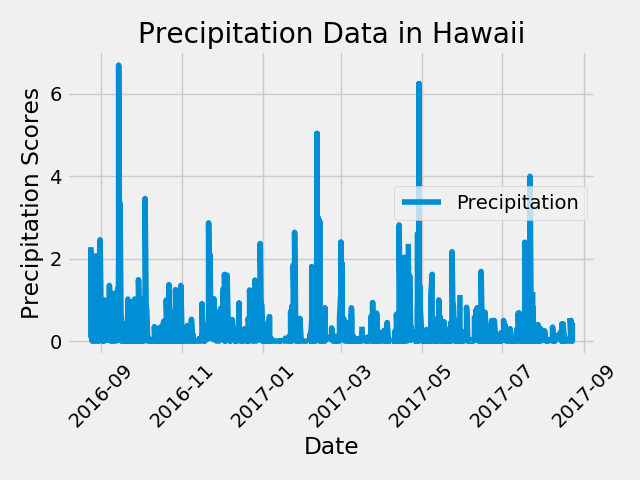

In [213]:
# let's use matplotlib to plot the data
precipitation_DF.plot()
plt.xlabel('Date')
plt.ylabel('Precipitation Scores')
plt.title("Precipitation Data in Hawaii")
plt.legend(['Precipitation'])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.savefig('C:/Users/CAEAIZPU/OneDrive - kochind.com/Desktop/Advanced Data Storage/FIG1.png')

In [184]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_DF.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [185]:
# How many stations are available in this dataset?
stations = session.query(func.count(Station.station))
station_count = stations[0]
station_count

(9)

In [186]:
# if looking into measurement data
stations_2 = session.query(Measurement).group_by(Measurement.station).count()
stations_2

9

In [187]:
# What are the most active stations?
# List the stations and the counts in descending order.
count = session.query(Measurement.station, func.count(Measurement.prcp))\
    .group_by(Measurement.station)\
    .order_by(func.count(Measurement.prcp).desc())

#printing results
for station in count:
    print(station)
    
top_station = count[0][0]


('USC00519281', 2772)
('USC00513117', 2696)
('USC00519397', 2685)
('USC00519523', 2572)
('USC00516128', 2484)
('USC00514830', 1937)
('USC00511918', 1932)
('USC00517948', 683)
('USC00518838', 342)


In [204]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
temperature = session.query(Measurement.station, Measurement.date, Measurement.tobs).\
    filter(Measurement.station == top_station).\
    filter(Measurement.date > last_year_data).\
    order_by(Measurement.date).all()

temperature_DF = pd.DataFrame(temperature)
temperature_DF.head()

,station,date,tobs
0,USC00519281,2016-08-24,77.0
1,USC00519281,2016-08-25,80.0
2,USC00519281,2016-08-26,80.0
3,USC00519281,2016-08-27,75.0
4,USC00519281,2016-08-28,73.0


In [205]:
temperature_DF.max()

station    USC00519281
date        2017-08-18
tobs                83
dtype: object

In [206]:
temperature_DF.min()

station    USC00519281
date        2016-08-24
tobs                59
dtype: object

In [207]:
temperature_DF.mean()

tobs    73.096866
dtype: float64

In [208]:
temperature_DF['date_2'] = pd.to_datetime(temperature_DF['date']).dt.date
del temperature_DF['date']
temperature_DF.head()

,station,tobs,date_2
0,USC00519281,77.0,2016-08-24
1,USC00519281,80.0,2016-08-25
2,USC00519281,80.0,2016-08-26
3,USC00519281,75.0,2016-08-27
4,USC00519281,73.0,2016-08-28


<IPython.core.display.Javascript object>


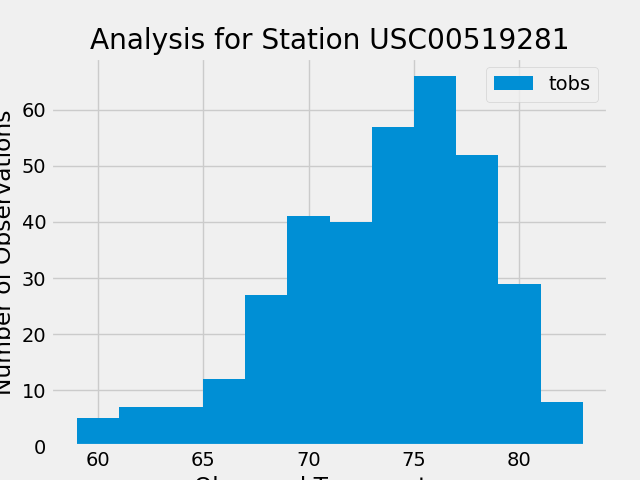

In [236]:
# plot the temperature data in a histogram

temperature_DF.iloc[::1].plot.hist(bins = 12)
plt.xlabel("Observed Temperature")
plt.ylabel("Number of Observations")
plt.title("Analysis for Station " + top_station)

plt.show()

plt.savefig('C:/Users/CAEAIZPU/OneDrive - kochind.com/Desktop/Advanced Data Storage/FIG2.png')




In [215]:
# The starter notebook contains a function called calc_temps that 
# will accept a start date and end date in the format %Y-%m-%d 
# and return the minimum, average, and maximum temperatures for that range of dates.

def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [219]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

first_day = dt.date(2017, 8, 11)
last_day = dt.date(2017, 8, 23)
last_year = dt.timedelta(days=365)
temp_avg_lst_year = (calc_temps((first_day-last_year), (last_day-last_year)))
print(temp_avg_lst_year)

[(71.0, 78.01190476190476, 83.0)]


<IPython.core.display.Javascript object>


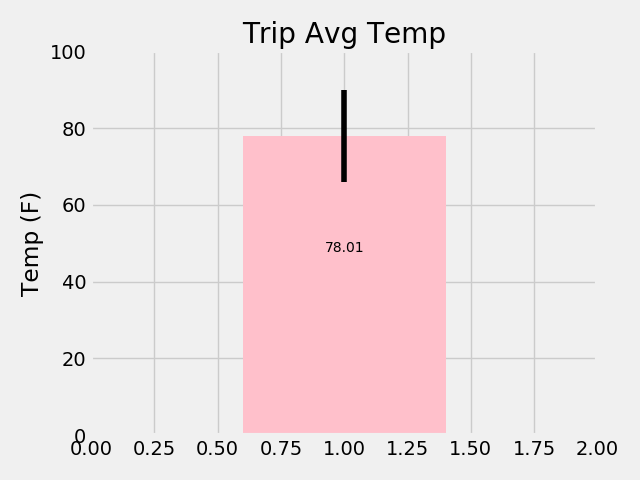

In [235]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
# Plotting bar
p2p = temp_avg_lst_year[0][2]-temp_avg_lst_year[0][0]
avgtemp = temp_avg_lst_year[0][1]
min_temp = temp_avg_lst_year[0][0]
max_temp = temp_avg_lst_year[0][2]

fig, ax = plt.subplots()
bar_chart = ax.bar(1 , avgtemp, color= 'pink', yerr=p2p)
ax.set_ylabel("Temp (F)")
ax.set_title("Trip Avg Temp")

def autolabels(rects):
    for rect in rects:
        h=rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., .6*h,'%.2f' % float(h) ,ha='center', va='bottom', fontsize=10)

        
    # label the bars 
autolabels(bar_chart)        
plt.ylim(0, 100)
plt.xlim(0,2)
fig.tight_layout()
plt.show()

plt.savefig('C:/Users/CAEAIZPU/OneDrive - kochind.com/Desktop/Advanced Data Storage/FIG3.png')